In [2]:
from fastai.vision.all import *
import torch
torch.backends.mps.is_available() # metal GPU acceleration

True

In [3]:
FPS = 3
H, W, C = 512, 512, 3
NUM_FRAMES = 30 # 10s

In [4]:
from sklearn.model_selection import train_test_split


def chunk_splitter(total_size: int, chunk_size: int, split: int | float) -> np.array:
    _, val_idxs = train_test_split(np.arange(total_size // chunk_size), test_size=split, random_state=42) # ignoring final unsized chunk
    is_valid = np.zeros(total_size, dtype=np.int8)

    for index in val_idxs:
        index *= chunk_size
        is_valid[index:index+chunk_size] = 1

    return is_valid

In [7]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms 

# Define the duration of each chunk in seconds
chunk_duration_s = 10
chunk_duration_frames = 3 * chunk_duration_s

# Define the path to the video frames directory
frames_directory = 'frames/labeled_data/'

# Create the ImageFolder dataset
dataset = ImageFolder(root=frames_directory)
# Calculate the total number of chunks
split = chunk_splitter(len(dataset), chunk_size=chunk_duration_frames, split=.15)

In [8]:
dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                    get_items=get_image_files,
                    splitter=MaskSplitter(split.astype("bool")),
                    get_y=parent_label,
                    item_tfms=Resize(224))
path = "frames/labeled_data/"
dls = ImageDataLoaders.from_dblock(dblock, path, path=path)

In [9]:
dls.train_ds, dls.valid_ds, len(split)

((#80730) [(PILImage mode=RGB size=512x512, TensorCategory(0)),(PILImage mode=RGB size=512x512, TensorCategory(0)),(PILImage mode=RGB size=512x512, TensorCategory(0)),(PILImage mode=RGB size=512x512, TensorCategory(0)),(PILImage mode=RGB size=512x512, TensorCategory(0)),(PILImage mode=RGB size=512x512, TensorCategory(0)),(PILImage mode=RGB size=512x512, TensorCategory(0)),(PILImage mode=RGB size=512x512, TensorCategory(0)),(PILImage mode=RGB size=512x512, TensorCategory(0)),(PILImage mode=RGB size=512x512, TensorCategory(0))...],
 (#14250) [(PILImage mode=RGB size=512x512, TensorCategory(0)),(PILImage mode=RGB size=512x512, TensorCategory(0)),(PILImage mode=RGB size=512x512, TensorCategory(0)),(PILImage mode=RGB size=512x512, TensorCategory(0)),(PILImage mode=RGB size=512x512, TensorCategory(0)),(PILImage mode=RGB size=512x512, TensorCategory(0)),(PILImage mode=RGB size=512x512, TensorCategory(0)),(PILImage mode=RGB size=512x512, TensorCategory(0)),(PILImage mode=RGB size=512x512, Tens

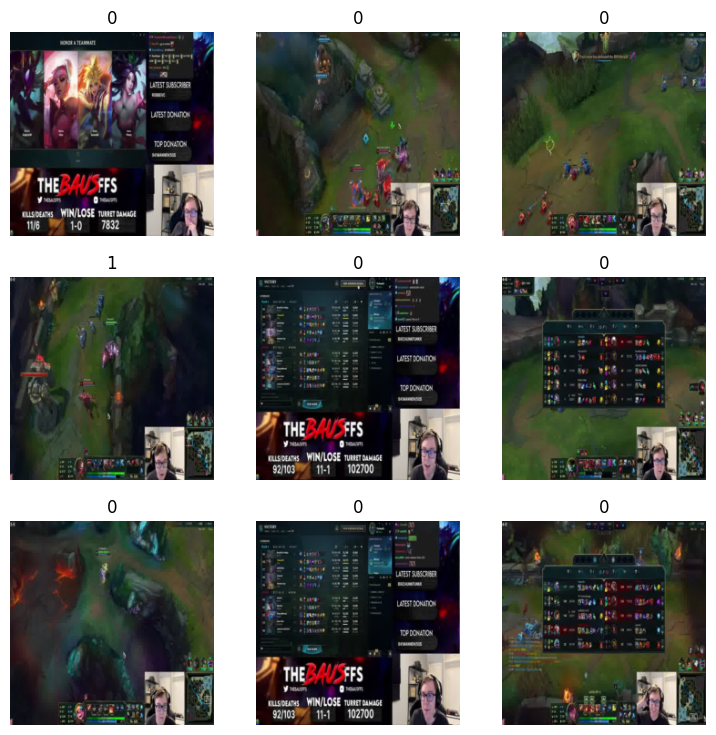

In [10]:
dls.show_batch()

In [11]:
learn = vision_learner(dls, resnet50, metrics=[error_rate, F1Score()])

/Users/londogard/micromamba/envs/lol_highlights/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/londogard/micromamba/envs/lol_highlights/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.00363078061491251)

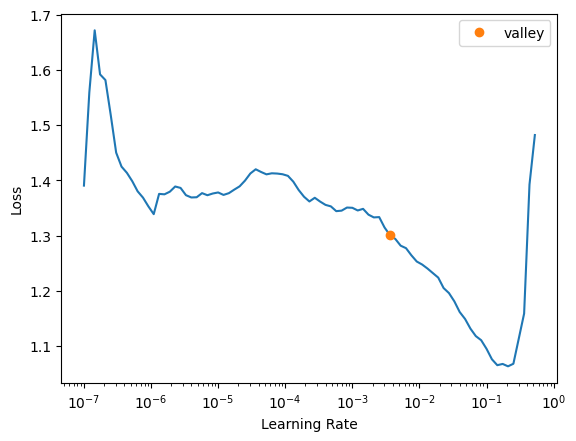

In [12]:
learn.lr_find()

In [13]:
learn.fine_tune(3, 0.00363078061491251)

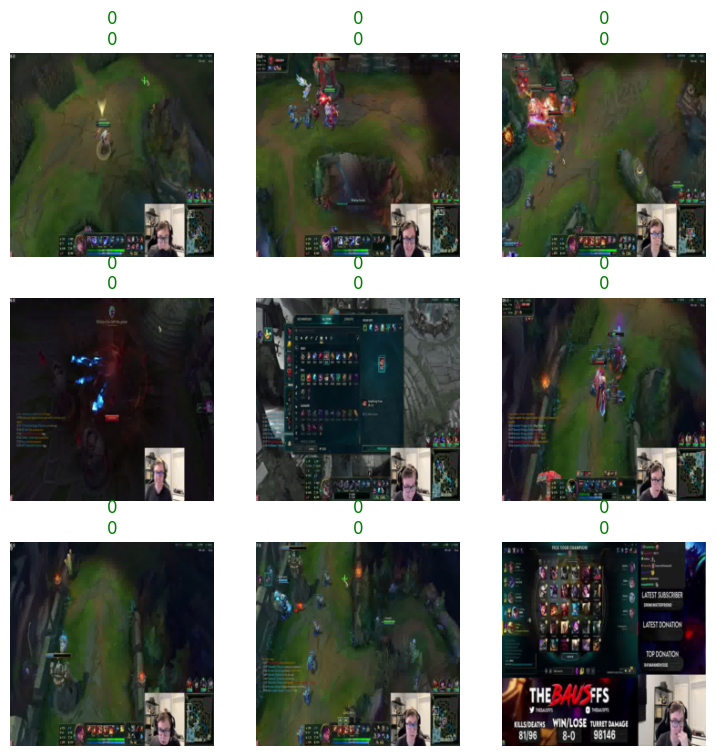

In [14]:
learn.show_results()

In [15]:
interp = ClassificationInterpretation.from_learner(learn)

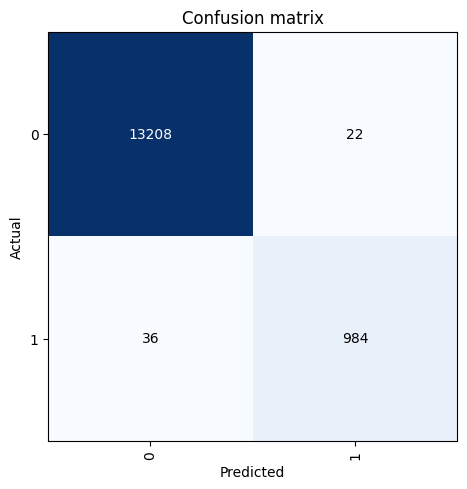

In [16]:
interp.plot_confusion_matrix()

In [17]:
interp.print_classification_report()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13230
           1       0.98      0.96      0.97      1020

    accuracy                           1.00     14250
   macro avg       0.99      0.98      0.98     14250
weighted avg       1.00      1.00      1.00     14250



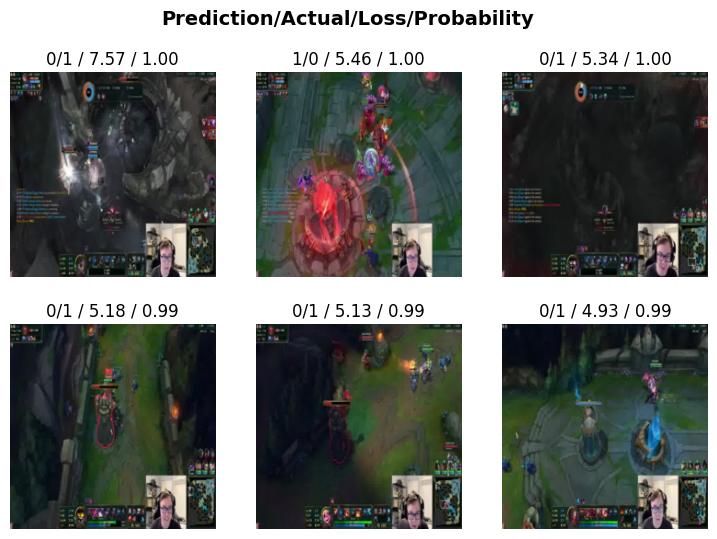

In [18]:
interp.plot_top_losses(k=6)

In [19]:
dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                    get_items=get_image_files,
                    splitter=MaskSplitter(split.astype("bool")),
                    get_y=parent_label,
                    item_tfms=Resize(224))
path = "frames/labeled_data/"
dls = ImageDataLoaders.from_dblock(dblock, path, path=path)

In [20]:
preds = learn.get_preds(with_decoded=True)
preds

(tensor([[1.0000e+00, 2.5711e-06],
         [9.9995e-01, 4.7494e-05],
         [9.9999e-01, 9.9799e-06],
         ...,
         [8.3878e-01, 1.6122e-01],
         [3.5604e-04, 9.9964e-01],
         [2.3585e-04, 9.9976e-01]]),
 tensor([0, 0, 0,  ..., 1, 1, 1]),
 tensor([0, 0, 0,  ..., 0, 1, 1]))

In [21]:
import plotly.express as px
import polars as pl
df = pl.DataFrame({"x": pl.arange(0, len(preds[1]), eager=True), "target": preds[1].numpy(), "pred": preds[2].numpy()})
df = df.with_columns(pred=- 1 * (pl.col("pred").rolling_mean(10, min_periods=0) > 0.5))

px.line(df, x="x", y=["pred", "target"])

In [22]:
dls_test = ImageDataLoaders.from_folder("frames/1880382999/", valid_pct=.00001, shuffle=False)

In [26]:
preds_test = learn.get_preds(dl=dls_test, with_decoded=True)

/Users/londogard/micromamba/envs/lol_highlights/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.



In [24]:
learn.export("/Users/londogard/git/hlondogard/lol_highlight_detection/fastai_resnet50.pth")

In [31]:
preds_test

(tensor([[9.9942e-01, 5.8270e-04],
         [9.9981e-01, 1.9332e-04],
         [9.9963e-01, 3.7487e-04],
         ...,
         [9.9992e-01, 7.5357e-05],
         [9.9981e-01, 1.8764e-04],
         [9.9982e-01, 1.7992e-04]]),
 tensor([0, 0, 0,  ..., 0, 0, 0]),
 tensor([0, 0, 0,  ..., 0, 0, 0]))

In [28]:
from datetime import timedelta
core_date = pl.datetime(0,0,0,0,0,0,0)
df = pl.DataFrame({
    "x": pl.arange(0, len(preds_test[1]), eager=True) / 3,
    "y": pl.Series(preds_test[1].numpy())
    })

px.line(df, x="x", y="y")